In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('data/train.csv')  # your_data.csv 를 실제 파일 경로나 URL로 변경하세요.

# NA 값 확인
print(df.isna().sum())

inst_id                0
OC                     0
sido                   0
sgg                    0
openDate               0
bedCount               5
instkind               1
revenue1               8
salescost1             8
sga1                   8
salary1                8
noi1                   8
noe1                   8
interest1              8
ctax1                  8
profit1                8
liquidAsset1           8
quickAsset1            8
receivableS1           8
inventoryAsset1        8
nonCAsset1             8
tanAsset1              8
OnonCAsset1            8
receivableL1           8
debt1                  8
liquidLiabilities1     8
shortLoan1             8
NCLiabilities1         8
longLoan1              8
netAsset1              8
surplus1               8
revenue2               8
salescost2             8
sga2                   8
salary2                8
noi2                   8
noe2                   8
interest2              8
ctax2                  8
profit2                8


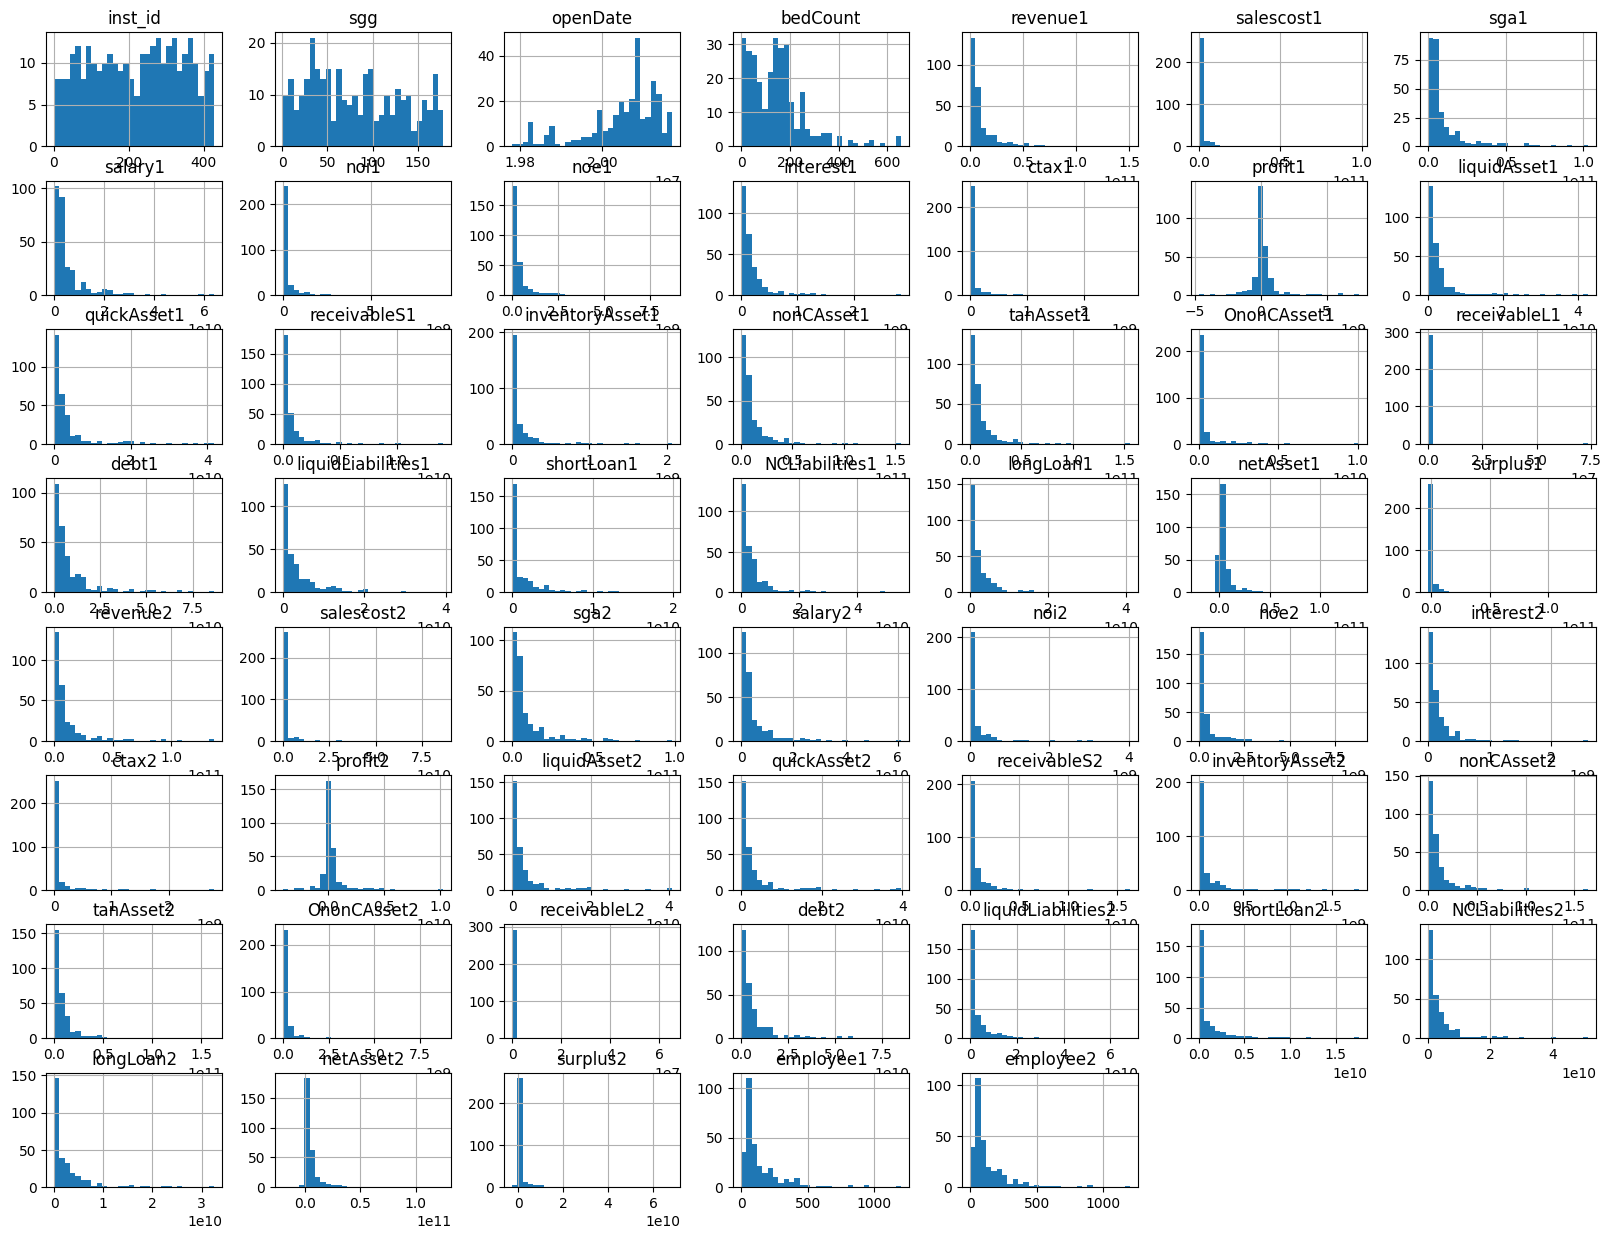

/tmp/ipykernel_617090/1629514863.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')


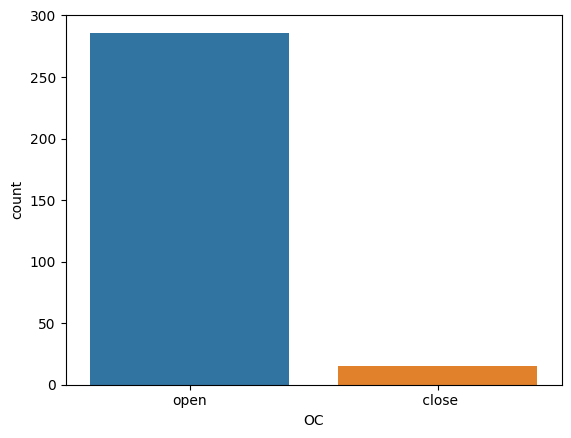

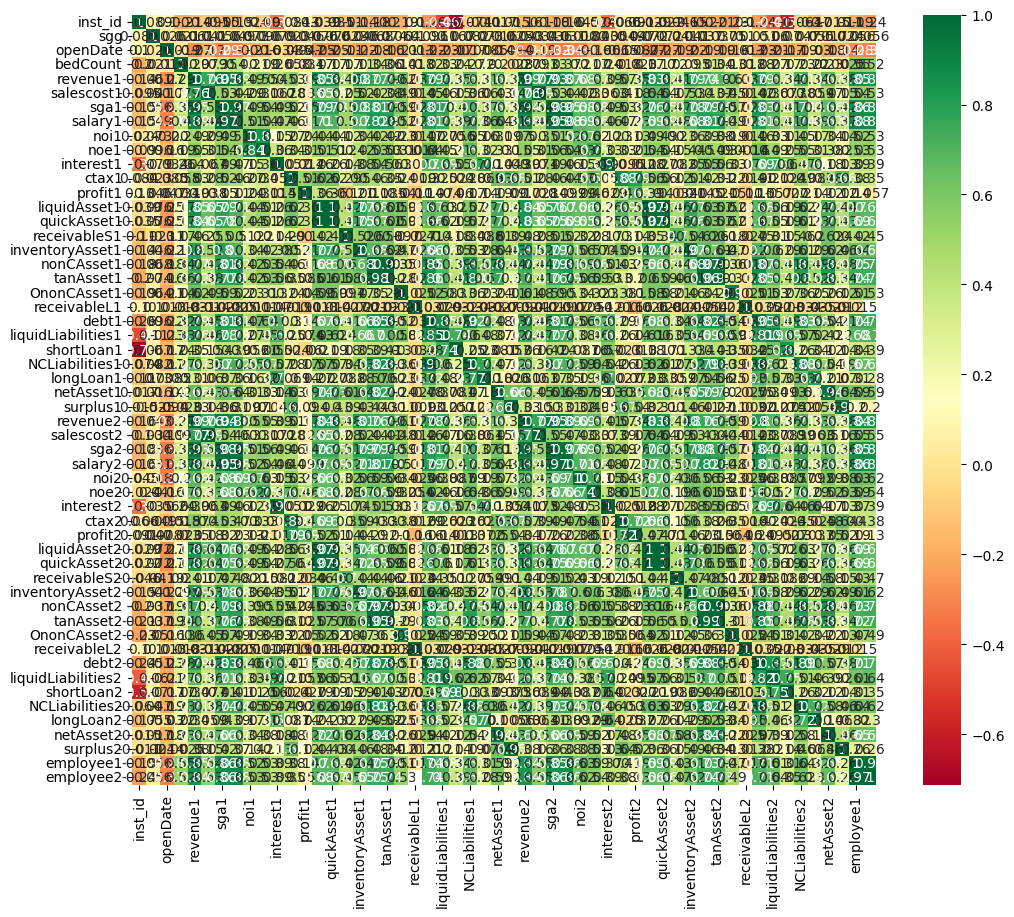

In [2]:
# 각 feature들의 분포 확인
df.hist(bins=30, figsize=(20,15))
plt.show()

# 개폐업(OC)에 대한 countplot
sns.countplot(x="OC", data=df)

# 상관관계 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
plt.show()

In [3]:
# 카테고리형 변수 처리
le = LabelEncoder()
df['OC'] = le.fit_transform(df['OC'])
df['sido'] = le.fit_transform(df['sido'])
df['ownerChange'] = le.fit_transform(df['ownerChange'])
df['instkind'] = le.fit_transform(df['instkind'])

# NA 값 처리 예시
df = df.fillna(0)

# X, y 분리
X = df.drop(['OC'], axis=1)
y = df['OC']

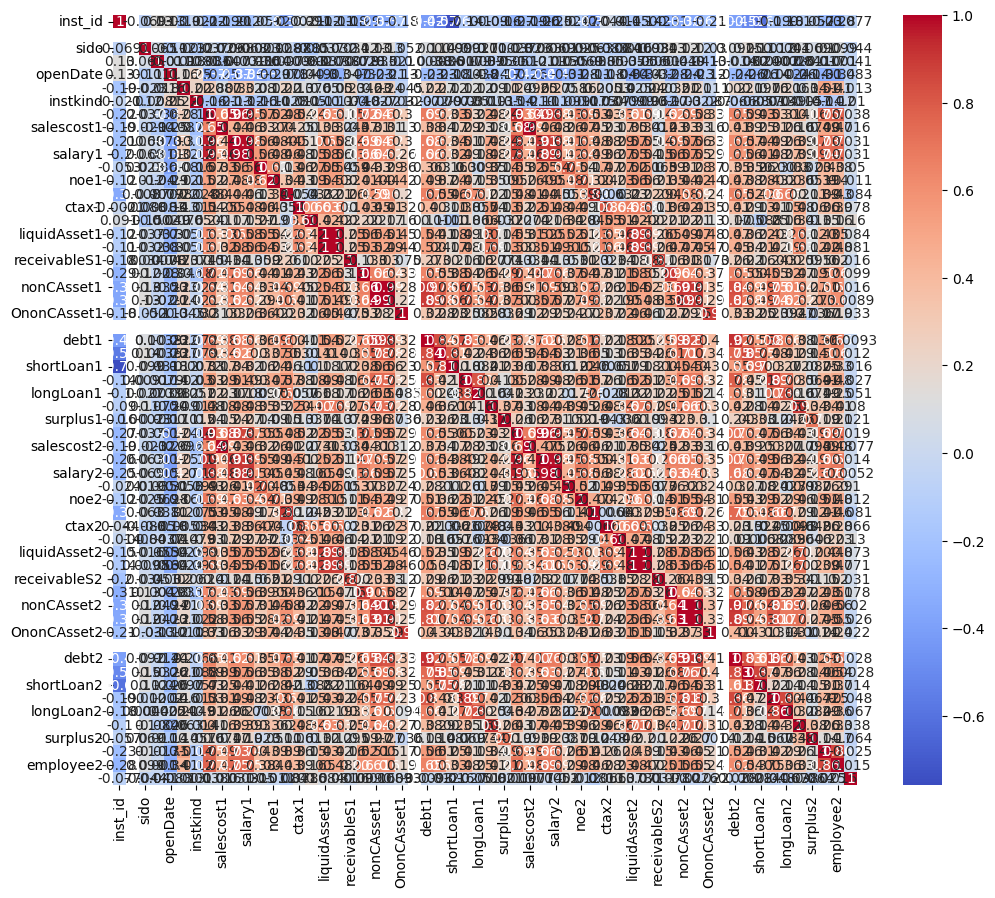

quickAsset2   liquidAsset2    0.999211
liquidAsset2  quickAsset2     0.999211
quickAsset1   liquidAsset1    0.999175
liquidAsset1  quickAsset1     0.999175
tanAsset2     nonCAsset2      0.997537
nonCAsset2    tanAsset2       0.997537
tanAsset1     nonCAsset1      0.994969
nonCAsset1    tanAsset1       0.994969
salescost1    salescost2      0.988380
salescost2    salescost1      0.988380
salary1       sga1            0.981012
sga1          salary1         0.981012
salary2       sga2            0.978021
sga2          salary2         0.978021
sga1          revenue1        0.963287
revenue1      sga1            0.963287
sga2          revenue2        0.959898
revenue2      sga2            0.959898
revenue1      salary1         0.953182
salary1       revenue1        0.953182
revenue2      salary2         0.950301
salary2       revenue2        0.950301
revenue1      revenue2        0.933054
revenue2      revenue1        0.933054
debt2         debt1           0.919874
debt1         debt2      

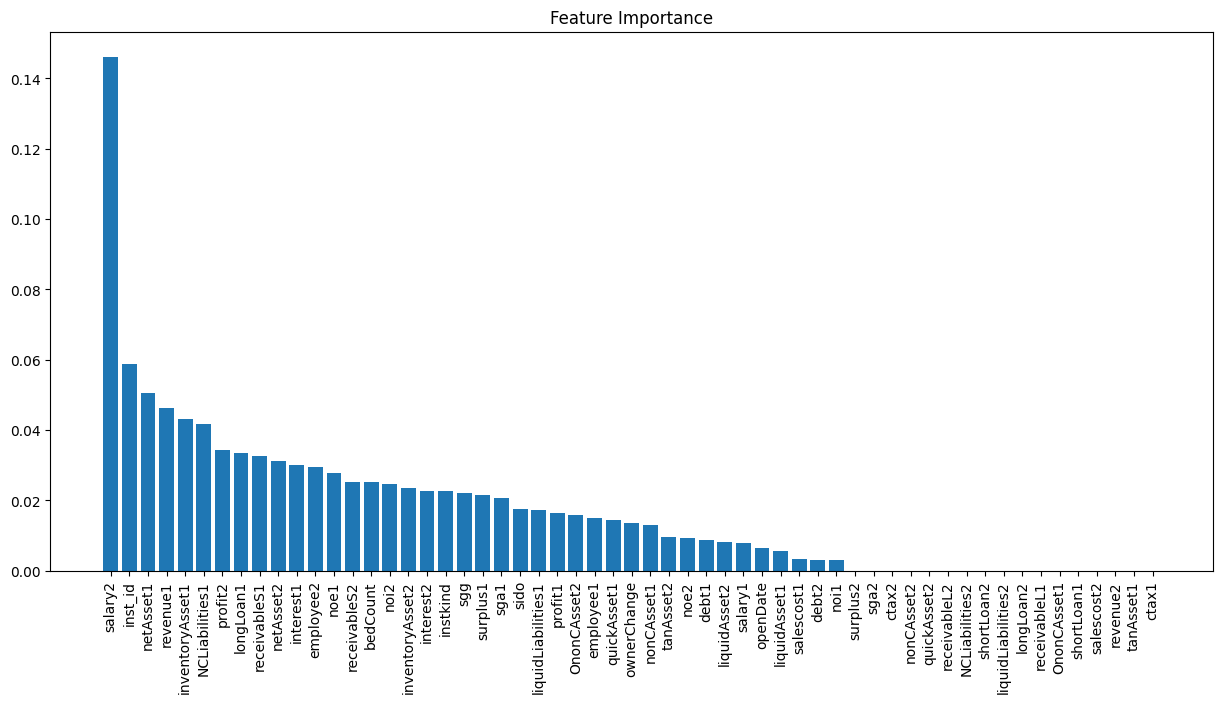

Accuracy:  0.9478260869565217
F1 Score:  0.9516129032258065
Precision:  1.0
Recall:  0.9076923076923077
ROC AUC Score:  0.9538461538461538
PR AUC Score:  0.959866220735786


In [4]:
# 필요한 라이브러리 import
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from scipy import stats

# 이상치 제거
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

# 다중공선성 확인
correlation = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

# 상관 계수가 0.9 이상인 특성 쌍 찾기
corr_pairs = correlation.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > 0.9) & (abs(corr_pairs) < 1.0)].sort_values(ascending=False)
print(high_corr)

# PCA를 통해 다중공선성 문제 해결
pca = PCA()
X_pca = pca.fit_transform(X)

# 특성 중요도 확인
model = XGBClassifier()
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize=(15, 7))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

# 중요도가 높은 특성만 선택
sfm = SelectFromModel(model, threshold=0.01)  # 임계값은 조절 가능
sfm.fit(X, y)
X_important = sfm.transform(X)

# 데이터 불균형 처리
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# 다시 XGBoost 모델 학습 및 평가
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 성능 지표 출력
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))
print("PR AUC Score: ", average_precision_score(y_test, y_pred))


In [5]:
print(len(X_smote))
print(len(y_smote))

from sklearn.metrics import confusion_matrix
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))


572
572
